## **In today’s data-driven world, data science and programming have enabled us to leverage machine learning and artificial intelligence techniques to solve complex optimization problems, such as portfolio optimization.We’ll explore how to use a genetic algorithm to optimize a portfolio and improve its performance. We’ll see the underlying theory and implementation details of the genetic algorithm and demonstrate how to apply it to real-world financial data.**

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


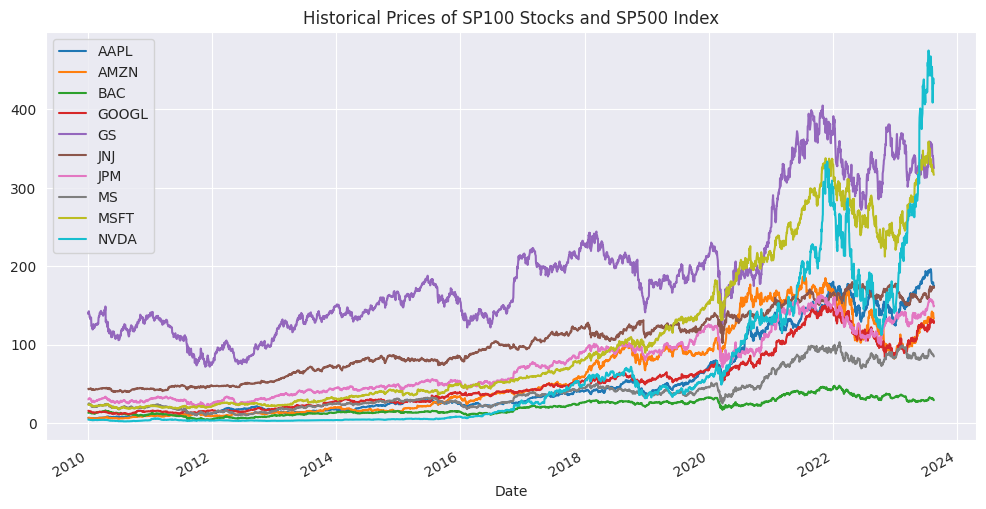

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']
start_date = '2010-01-01'
data = yf.download(stocks, start=start_date)['Adj Close']
benchmark = yf.download('^OEX', start=start_date)['Adj Close']

# Visualize the data
sns.set_style('darkgrid')
data.plot(figsize=(12, 6))
plt.title('Historical Prices of SP100 Stocks and SP500 Index')
plt.legend(loc='upper left')
plt.show()

The genetic algorithm in portfolio optimization involves the following steps:

Creating a random population of portfolio weight vectors that represent candidate solutions to the portfolio optimization problem.

Calculating the objective function for each candidate solution in the population to evaluate their fitness.

Selecting the fittest individuals in the population to be the parents for the next generation using techniques like tournament selection.

Creating new offspring through crossover and mutation of the parents to increase genetic diversity.

Normalizing the weights of the offspring to sum to 1 and replacing any negative weights with 0 to ensure the offspring population has valid weights.

Repeating the process from step 2 until the termination criteria are met, using the offspring population as the new generation.

In [2]:
import numpy as np

# Define the fitness function to maximize the Sharpe Ratio
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()

    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio

In [3]:
# Define the genetic algorithm
def genetic_algorithm(data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1):
    # Initialize the population
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]

    # Calculate fitness of initial population
    fitness = np.array([fitness_function(individual, data) for individual in population])

    for generation in range(num_generations):
        # Sort the population by fitness
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # Determine number of individuals to carry over via elitism
        num_elites = int(elitism * population_size)

        # Create the next generation, starting with the elites
        offspring = population[:num_elites]

        # Select parents for reproduction using tournament selection
        parent1_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent2_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # Perform crossover and mutation to create the next generation
        crossover_prob = np.random.rand(population_size-num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_direction = np.random.choice([-1, 1], size=(population_size-num_elites, len(data.columns)))
        offspring_mutation = np.where(mutation_mask, offspring_crossover + mutation_direction * mutation_values, offspring_crossover)

        # Ensure the offspring population has valid weights
        offspring_mutation = offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]

        # Combine elites and offspring to create the next generation
        population = np.vstack((population[:num_elites], offspring_mutation))

        # Calculate fitness of new population
        fitness = np.array([fitness_function(individual, data) for individual in population])

    # Return the best individual from the final population
    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print('Best Sharpe Ratio: ', np.max(fitness))

    return best_individual

Best Sharpe Ratio:  1.006786750195769


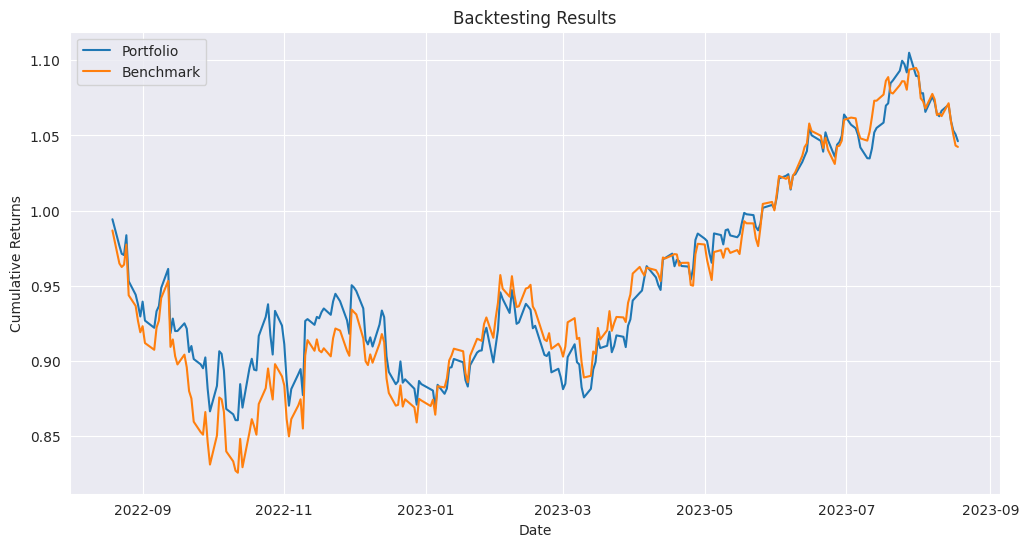

Portfolio Statistics:
---------------------
Mean Daily Return: 0.0003
Standard Deviation: 0.0120
Sharpe Ratio: 0.3330
Final Value: 1046.14

Benchmark Statistics:
---------------------
Mean Daily Return: 0.0002
Standard Deviation: 0.0121
Sharpe Ratio: 0.3126
Final Value: 1042.37


In [4]:
# Implement the genetic algorithm in backtesting
from datetime import datetime, timedelta

# Seed for reproducibility
np.random.seed(42)

def backtest(genetic_algorithm, data, benchmark, initial_capital):
    # Split the data into training and testing sets
    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    # Run the genetic algorithm on the training set to find the optimal portfolio weights
    weights = genetic_algorithm(data=train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)
    # print(weights)

    # Set any negative weights to 0
    weights[weights < 0] = 0

    # Normalize remaining positive weights to sum to 1
    weights /= weights.sum()

    # Calculate the returns of the portfolio and the benchmark on the test set
    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()
    benchmark_cum_returns = np.cumprod(1 + benchmark_returns)
    benchmark_value = initial_capital * benchmark_cum_returns[-1]

    # Calculate performance metrics
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)
    benchmark_std = np.std(benchmark_returns)
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    # print(portfolio_cum_returns)

    # Visualize the performance of the portfolio and the benchmark
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label='Portfolio')
    ax.plot(benchmark_cum_returns, label='Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title('Backtesting Results')
    ax.legend()
    plt.show()

    # Print performance metrics
    print('Portfolio Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(portfolio_mean_return))
    print('Standard Deviation: {:.4f}'.format(portfolio_std))
    print('Sharpe Ratio: {:.4f}'.format(portfolio_sharpe_ratio))
    print('Final Value: {:.2f}'.format(portfolio_value))
    print('')
    print('Benchmark Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(benchmark_mean_return))
    print('Standard Deviation: {:.4f}'.format(benchmark_std))
    print('Sharpe Ratio: {:.4f}'.format(benchmark_sharpe_ratio))
    print('Final Value: {:.2f}'.format(benchmark_value))

    return portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns

portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

Best Sharpe Ratio:  1.0405165085907693
Best Sharpe Ratio:  0.9734098419368862
Best Sharpe Ratio:  0.9918809360779597
Best Sharpe Ratio:  0.9715409199390742
Best Sharpe Ratio:  0.9673278342326052
Best Sharpe Ratio:  0.9229353127222499
Best Sharpe Ratio:  0.9362616340405707
Best Sharpe Ratio:  0.9578314391479087
Best Sharpe Ratio:  0.9777685134483353
Best Sharpe Ratio:  1.011387294853292
Best Sharpe Ratio:  0.997480765823302


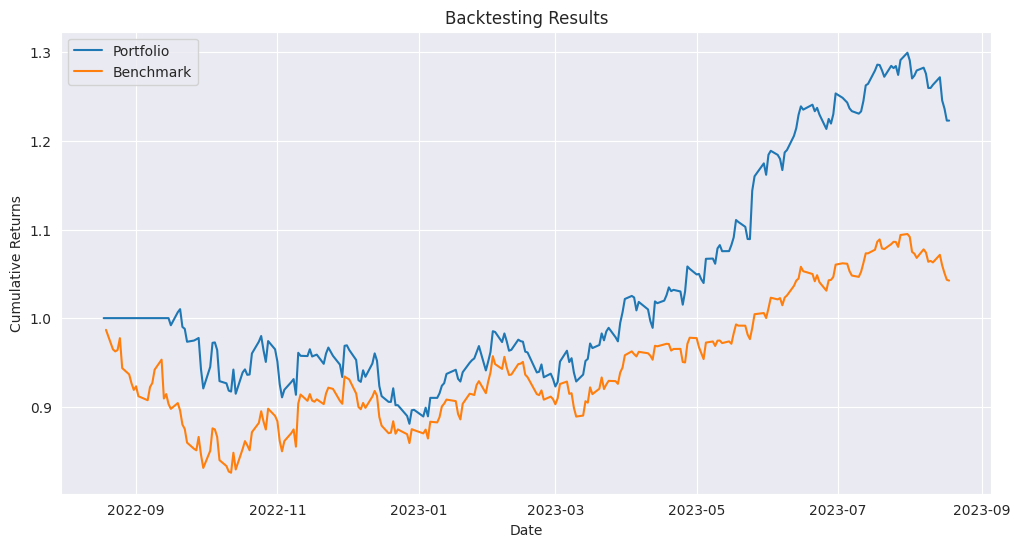

Portfolio Statistics:
---------------------
Mean Daily Return: 0.09%
Standard Deviation: 4.42%
Sharpe Ratio: -0.32
Final Value: 1222.93

Benchmark Statistics:
---------------------
Mean Daily Return: 0.02%
Standard Deviation: 4.21%
Sharpe Ratio: -0.35
Final Value: 1042.37



In [5]:
# Seed for reproducibility
np.random.seed(42)

def backtest_monthly(optimization_function, data, benchmark, initial_capital):

    # Initialize the portfolio value and the portfolio weights
    # initial_capital = 1000
    portfolio_value = initial_capital
    test_data = data.iloc[-252:]

    # Initialize history of weights and portfolio values
    weights_history = pd.DataFrame(index=test_data.index, columns=data.columns)
    portfolio_value_history = pd.Series(index=test_data.index, name='Portfolio Value', dtype='float')
    portfolio_value_history.iloc[0] = portfolio_value

    # Loop through the data one month at a time
    for i in range(21, len(test_data), 21):
        # Get the data for the current month
        month_data = test_data.iloc[i-21:i]

        # Call the optimization function to get the portfolio weights for the current month
        train_data = data.loc[:month_data.index[0]]
        weights = optimization_function(train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)

        # Set any negative weights to 0
        weights[weights < 0] = 0

        # Normalize remaining positive weights to sum to 1
        weights /= weights.sum()

        # Save the weights for the current month
        weights_history.loc[month_data.index[-1]] = weights
        month_returns = month_data.pct_change() * weights

        # Loop through the data one day at a time
        for j in range(1, len(month_returns)):
            # Calculate the portfolio value for the current day
            day_returns = month_returns.iloc[j]
            portfolio_value = (1 + day_returns.sum()) * portfolio_value

            # Update the portfolio value and save it to the history
            portfolio_value_history.loc[month_returns.index[j]] = portfolio_value

    # Calculate the portfolio returns and the benchmark returns
    weights_history = weights_history.fillna(method='ffill')
    portfolio_returns = (weights_history[:-1] * test_data.pct_change()[1:]).sum(axis=1)
    benchmark_returns = benchmark.iloc[-252:].pct_change()[1:]


    # Calculate the statistics
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()
    portfolio_mean_return = portfolio_returns.mean()
    benchmark_mean_return = benchmark_returns.mean()
    portfolio_volatility = portfolio_returns.std() * np.sqrt(12)
    benchmark_volatility = benchmark_returns.std() * np.sqrt(12)
    sharpe_ratio = (portfolio_mean_return - 0.015) / portfolio_volatility
    benchmark_sharpe_ratio = (benchmark_mean_return - 0.015) / benchmark_volatility

    # Portfolio & Benchmark value
    benchmark_value = initial_capital * benchmark_cumulative_returns[-1]
    portfolio_value = initial_capital * portfolio_cumulative_returns[-1]


    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cumulative_returns, label='Portfolio')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    plt.legend(loc='upper left')
    plt.title('Backtesting Results')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

    # Print the portfolio statistics
    print('Portfolio Statistics:')
    print('---------------------')
    print(f'Mean Daily Return: {portfolio_mean_return:.2%}')
    print(f'Standard Deviation: {portfolio_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print('Final Value: {:.2f}'.format(portfolio_value))
    print()

    # Print the benchmark statistics
    print('Benchmark Statistics:')
    print('---------------------')
    print(f'Mean Daily Return: {benchmark_mean_return:.2%}')
    print(f'Standard Deviation: {benchmark_volatility:.2%}')
    print(f'Sharpe Ratio: {benchmark_sharpe_ratio:.2f}')
    print('Final Value: {:.2f}'.format(benchmark_value))
    print()


    return weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns

# Run backtesting
weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns = backtest_monthly(genetic_algorithm, data, benchmark, initial_capital=1000)